# Income Prediction using Boosting Algorithms (CatBoost and XGBoost)


## Data Source: https://archive.ics.uci.edu/dataset/2/adult

In [1]:
## Load required libraries

import pandas as pd
import numpy as np
import matplotlib as plt
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, auc
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [2]:
## Prepare training and testing datasets

with open('adult.names') as fp:
    cols = []
    for line in fp:
        sre = re.match(r'(?P<colname>[a-z\-]+):.*\.', line)
        if sre:
            cols.append(sre.group('colname'))
    cols.append('label')

options = {'header': None, 'names': cols, 'skipinitialspace': True}

# adult.data
train_df = pd.read_csv('adult.data', **options)

# adult.test
test_df = pd.read_csv('adult.test', skiprows=1, **options)
test_df['label'] = test_df['label'].str.rstrip('.')

In [3]:
for col in test_df.columns:
    if test_df[col].dtype == 'O':
        test_df[col] = test_df[col].str.strip()
        
for col in train_df.columns:
    if train_df[col].dtype == 'O':
        train_df[col] = train_df[col].str.strip()

In [4]:
## Combine training and testing data for Exploratory Data Aanalysis
df_train = train_df.copy()
df_test = test_df.copy()
df_test["label"] = -888
df = pd.concat([df_train, df_test])
print(df_test.shape)

(16281, 15)


In [5]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  label           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 6.0+ MB


In [7]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### Univariate Analysis

<AxesSubplot:xlabel='native-country', ylabel='count'>

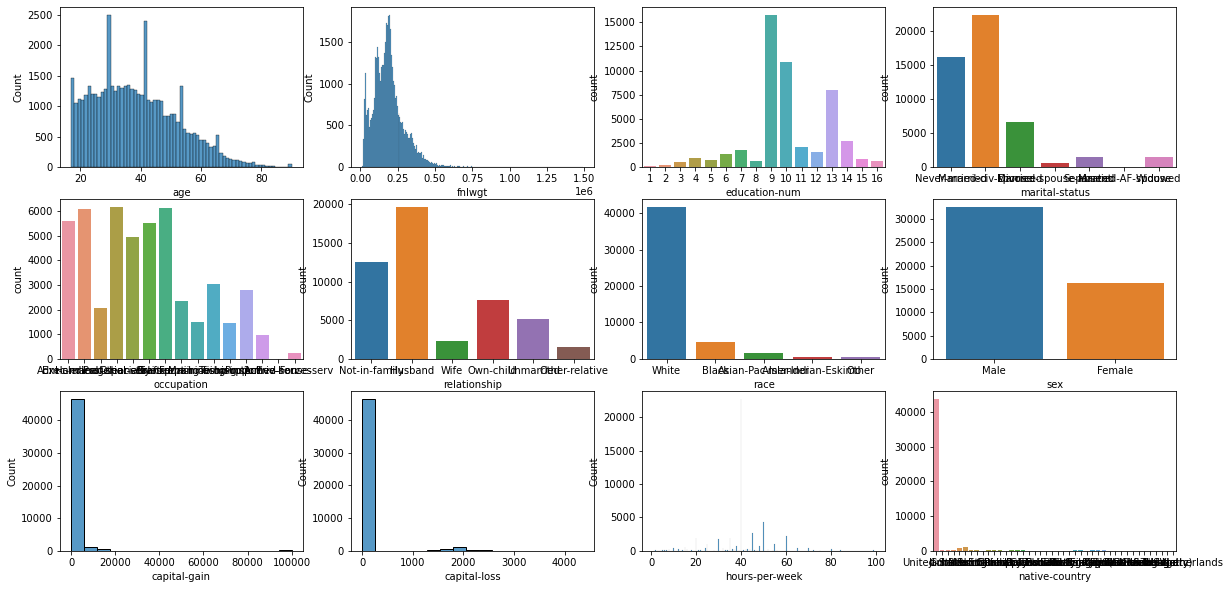

In [8]:
f, axes = plt.subplots(3, 4,figsize=(20, 10))
sns.histplot(  df['age'],    ax=axes[0,0])
sns.histplot(  df['fnlwgt'],    ax=axes[0,1])
#sns.boxplot(  df['fnlwgt'], data=df,  orient='v' , ax=axes[0,1])
sns.countplot(  x = df['education-num'], data=df,  orient='v' , ax=axes[0,2])
sns.countplot(  df['marital-status'], data=df,  orient='v' , ax=axes[0,3])
sns.countplot(  df['occupation'], data=df,  orient='v' , ax=axes[1,0])
sns.countplot(  df['relationship'], data=df,  orient='v' , ax=axes[1,1])
sns.countplot(  df['race'], data=df,  orient='v' , ax=axes[1,2])
sns.countplot(  df['sex'], data=df,  orient='v' , ax=axes[1,3])
sns.histplot(df['capital-gain'] , ax=axes[2,0])
sns.histplot(df['capital-loss'] , ax=axes[2,1])
sns.histplot(df['hours-per-week'] , ax=axes[2,2])
sns.countplot(df['native-country'] ,data=df,  orient='v' , ax=axes[2,3])

<AxesSubplot:xlabel='label', ylabel='count'>

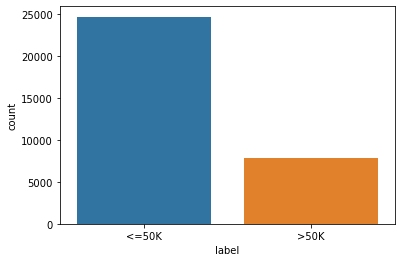

In [9]:
sns.countplot(train_df['label'],  orient='v')

<AxesSubplot:ylabel='Frequency'>

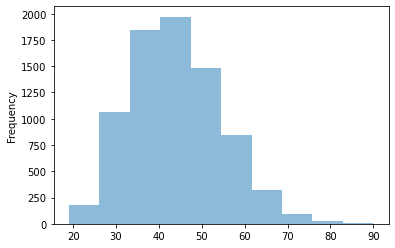

In [10]:
df[df['label'] == '>50K']['age'].plot(kind='hist', alpha=0.5, label='Label 0')

<AxesSubplot:xlabel='label'>

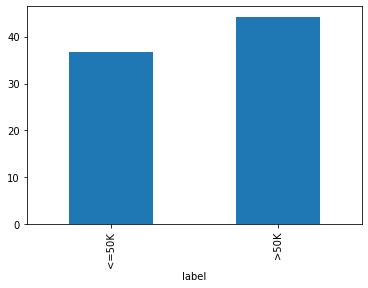

In [11]:
train_df.groupby('label')['age'].mean().plot(kind='bar')

In [12]:
encoded_df = df.copy()

## Map categorical features to numerical values
label_mapping = {'<=50K': 0, '>50K': 1, '-888': -888}
encoded_df["sex"] = np.where(df["sex"] == 'Male', 1, 0)
encoded_df["label"] = encoded_df["label"].replace(label_mapping)
encoded_df["native-country"] = np.where(df["native-country"] == 'United-States', 0, 1)

In [13]:
encoded_df.label.unique()

array([   0,    1, -888], dtype=int64)

In [14]:
# List of columns to one-hot encode
columns_to_encode = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', ]

# Apply one-hot encoding
encoded_df = pd.get_dummies(encoded_df, columns=columns_to_encode)

In [15]:
encoded_df.shape

(48842, 52)

In [16]:
label_encoder = LabelEncoder()
encoded_df['education'] = label_encoder.fit_transform(encoded_df['education'])
encoded_df.drop('education', axis = 1, inplace = True)

In [17]:
train = encoded_df[encoded_df['label']!= -888]
test = encoded_df[encoded_df['label']== -888]

In [18]:
y = train[["label"]]
x = train.drop(['label'],axis = 1)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state = 13)

In [20]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "CatBoost Classifier": CatBoostClassifier(),
    "XGBoost Classifier": XGBClassifier()
}

In [21]:
results = []
for model_name, model in models.items():
    print(model_name, model)
    model.fit(x_train, y_train)
    
    train_pred = model.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    
     # Predict on test data
    test_pred = model.predict(x_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    results.append({
    "Model": model_name,
    "Train Accuracy": train_accuracy,
    "Test Accuracy": test_accuracy
    })
results_df = pd.DataFrame(results)

print(results_df)

Logistic Regression LogisticRegression(max_iter=200)
Random Forest RandomForestClassifier()
Support Vector Machine SVC()
CatBoost Classifier <catboost.core.CatBoostClassifier object at 0x0000026142EEA130>
Learning rate set to 0.040318
0:	learn: 0.6498864	total: 142ms	remaining: 2m 21s
1:	learn: 0.6158608	total: 151ms	remaining: 1m 15s
2:	learn: 0.5842559	total: 160ms	remaining: 53.1s
3:	learn: 0.5562471	total: 168ms	remaining: 41.9s
4:	learn: 0.5304009	total: 177ms	remaining: 35.2s
5:	learn: 0.5070988	total: 184ms	remaining: 30.6s
6:	learn: 0.4874228	total: 192ms	remaining: 27.3s
7:	learn: 0.4681932	total: 201ms	remaining: 24.9s
8:	learn: 0.4548236	total: 210ms	remaining: 23.1s
9:	learn: 0.4420697	total: 218ms	remaining: 21.6s
10:	learn: 0.4286119	total: 226ms	remaining: 20.3s
11:	learn: 0.4176374	total: 235ms	remaining: 19.4s
12:	learn: 0.4076206	total: 244ms	remaining: 18.5s
13:	learn: 0.4005403	total: 252ms	remaining: 17.7s
14:	learn: 0.3919621	total: 261ms	remaining: 17.1s
15:	lear

159:	learn: 0.2847447	total: 2.07s	remaining: 10.9s
160:	learn: 0.2846368	total: 2.09s	remaining: 10.9s
161:	learn: 0.2844695	total: 2.1s	remaining: 10.9s
162:	learn: 0.2843052	total: 2.11s	remaining: 10.8s
163:	learn: 0.2841316	total: 2.12s	remaining: 10.8s
164:	learn: 0.2839080	total: 2.13s	remaining: 10.8s
165:	learn: 0.2838106	total: 2.15s	remaining: 10.8s
166:	learn: 0.2835896	total: 2.16s	remaining: 10.8s
167:	learn: 0.2832001	total: 2.17s	remaining: 10.8s
168:	learn: 0.2830646	total: 2.19s	remaining: 10.7s
169:	learn: 0.2829868	total: 2.2s	remaining: 10.7s
170:	learn: 0.2828523	total: 2.21s	remaining: 10.7s
171:	learn: 0.2826881	total: 2.22s	remaining: 10.7s
172:	learn: 0.2825830	total: 2.23s	remaining: 10.7s
173:	learn: 0.2824577	total: 2.24s	remaining: 10.7s
174:	learn: 0.2823375	total: 2.25s	remaining: 10.6s
175:	learn: 0.2821908	total: 2.27s	remaining: 10.6s
176:	learn: 0.2820495	total: 2.28s	remaining: 10.6s
177:	learn: 0.2819714	total: 2.3s	remaining: 10.6s
178:	learn: 0.2

324:	learn: 0.2648759	total: 4.02s	remaining: 8.34s
325:	learn: 0.2648102	total: 4.03s	remaining: 8.32s
326:	learn: 0.2646649	total: 4.04s	remaining: 8.31s
327:	learn: 0.2645386	total: 4.05s	remaining: 8.29s
328:	learn: 0.2644636	total: 4.06s	remaining: 8.28s
329:	learn: 0.2643843	total: 4.07s	remaining: 8.26s
330:	learn: 0.2642929	total: 4.08s	remaining: 8.24s
331:	learn: 0.2642031	total: 4.09s	remaining: 8.23s
332:	learn: 0.2641286	total: 4.1s	remaining: 8.21s
333:	learn: 0.2640606	total: 4.11s	remaining: 8.2s
334:	learn: 0.2639965	total: 4.12s	remaining: 8.18s
335:	learn: 0.2638143	total: 4.13s	remaining: 8.17s
336:	learn: 0.2636904	total: 4.14s	remaining: 8.15s
337:	learn: 0.2636083	total: 4.15s	remaining: 8.14s
338:	learn: 0.2635203	total: 4.17s	remaining: 8.12s
339:	learn: 0.2634259	total: 4.18s	remaining: 8.11s
340:	learn: 0.2633165	total: 4.19s	remaining: 8.09s
341:	learn: 0.2632531	total: 4.2s	remaining: 8.08s
342:	learn: 0.2631550	total: 4.21s	remaining: 8.07s
343:	learn: 0.2

493:	learn: 0.2520627	total: 5.94s	remaining: 6.08s
494:	learn: 0.2519957	total: 5.95s	remaining: 6.07s
495:	learn: 0.2519580	total: 5.96s	remaining: 6.06s
496:	learn: 0.2519028	total: 5.97s	remaining: 6.05s
497:	learn: 0.2518729	total: 5.99s	remaining: 6.03s
498:	learn: 0.2518257	total: 6s	remaining: 6.02s
499:	learn: 0.2517684	total: 6.01s	remaining: 6.01s
500:	learn: 0.2516882	total: 6.02s	remaining: 6s
501:	learn: 0.2516081	total: 6.04s	remaining: 5.99s
502:	learn: 0.2515474	total: 6.05s	remaining: 5.97s
503:	learn: 0.2514886	total: 6.06s	remaining: 5.96s
504:	learn: 0.2514298	total: 6.07s	remaining: 5.95s
505:	learn: 0.2513821	total: 6.08s	remaining: 5.94s
506:	learn: 0.2513212	total: 6.09s	remaining: 5.92s
507:	learn: 0.2512794	total: 6.11s	remaining: 5.91s
508:	learn: 0.2512309	total: 6.12s	remaining: 5.9s
509:	learn: 0.2511938	total: 6.13s	remaining: 5.89s
510:	learn: 0.2511385	total: 6.14s	remaining: 5.88s
511:	learn: 0.2510840	total: 6.16s	remaining: 5.87s
512:	learn: 0.25100

664:	learn: 0.2424117	total: 8.07s	remaining: 4.07s
665:	learn: 0.2423577	total: 8.09s	remaining: 4.05s
666:	learn: 0.2423174	total: 8.1s	remaining: 4.04s
667:	learn: 0.2422700	total: 8.11s	remaining: 4.03s
668:	learn: 0.2422268	total: 8.12s	remaining: 4.02s
669:	learn: 0.2421903	total: 8.13s	remaining: 4s
670:	learn: 0.2421566	total: 8.14s	remaining: 3.99s
671:	learn: 0.2421159	total: 8.15s	remaining: 3.98s
672:	learn: 0.2420466	total: 8.17s	remaining: 3.97s
673:	learn: 0.2420198	total: 8.18s	remaining: 3.96s
674:	learn: 0.2419948	total: 8.19s	remaining: 3.94s
675:	learn: 0.2419325	total: 8.2s	remaining: 3.93s
676:	learn: 0.2418537	total: 8.21s	remaining: 3.92s
677:	learn: 0.2417730	total: 8.22s	remaining: 3.9s
678:	learn: 0.2417200	total: 8.23s	remaining: 3.89s
679:	learn: 0.2416812	total: 8.24s	remaining: 3.88s
680:	learn: 0.2416202	total: 8.26s	remaining: 3.87s
681:	learn: 0.2416027	total: 8.27s	remaining: 3.85s
682:	learn: 0.2415360	total: 8.28s	remaining: 3.84s
683:	learn: 0.2415

831:	learn: 0.2344419	total: 10s	remaining: 2.03s
832:	learn: 0.2343997	total: 10.1s	remaining: 2.02s
833:	learn: 0.2343500	total: 10.1s	remaining: 2s
834:	learn: 0.2343045	total: 10.1s	remaining: 1.99s
835:	learn: 0.2342668	total: 10.1s	remaining: 1.98s
836:	learn: 0.2342061	total: 10.1s	remaining: 1.97s
837:	learn: 0.2341606	total: 10.1s	remaining: 1.96s
838:	learn: 0.2341002	total: 10.1s	remaining: 1.95s
839:	learn: 0.2340471	total: 10.2s	remaining: 1.93s
840:	learn: 0.2339963	total: 10.2s	remaining: 1.92s
841:	learn: 0.2339587	total: 10.2s	remaining: 1.91s
842:	learn: 0.2339118	total: 10.2s	remaining: 1.9s
843:	learn: 0.2338862	total: 10.2s	remaining: 1.89s
844:	learn: 0.2338437	total: 10.2s	remaining: 1.87s
845:	learn: 0.2337980	total: 10.2s	remaining: 1.86s
846:	learn: 0.2337509	total: 10.2s	remaining: 1.85s
847:	learn: 0.2337092	total: 10.2s	remaining: 1.84s
848:	learn: 0.2336618	total: 10.3s	remaining: 1.82s
849:	learn: 0.2336283	total: 10.3s	remaining: 1.81s
850:	learn: 0.2335

              reg_alpha=None, reg_lambda=None, ...)
                    Model  Train Accuracy  Test Accuracy
0     Logistic Regression        0.793448       0.797936
1           Random Forest        0.999918       0.854440
2  Support Vector Machine        0.793489       0.797691
3     CatBoost Classifier        0.901679       0.871146
4      XGBoost Classifier        0.910975       0.870163


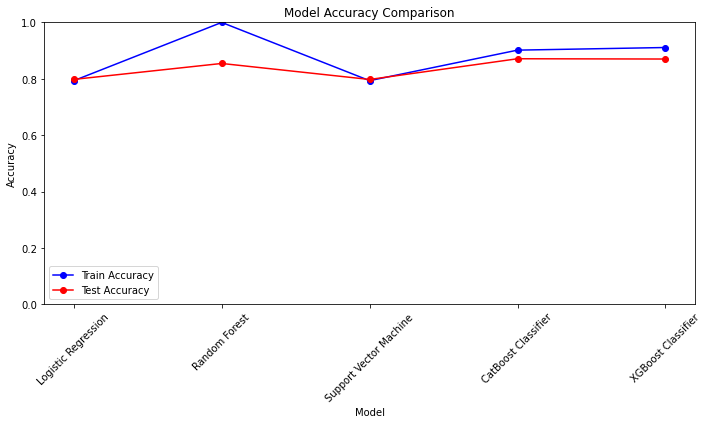

                    Model  Train Accuracy  Test Accuracy
0     Logistic Regression        0.793448       0.797936
1           Random Forest        0.999918       0.854440
2  Support Vector Machine        0.793489       0.797691
3     CatBoost Classifier        0.901679       0.871146
4      XGBoost Classifier        0.910975       0.870163


In [22]:
plt.figure(figsize=(10, 6))

# Plot train accuracy
plt.plot(results_df["Model"], results_df["Train Accuracy"], marker='o', label='Train Accuracy', color='b')

# Plot test accuracy
plt.plot(results_df["Model"], results_df["Test Accuracy"], marker='o', label='Test Accuracy', color='r')

# Add title and labels
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

print(results_df)

### CatBoost and XGBoost give the best initial accuracy.